In [1]:
!date
!pwd

Пнд Май 22 20:21:09 MSK 2017
/home/sphere/github/Sphere/separate


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import math as mt
import numpy as np

In [3]:
# функция построения всех попарных распределений признаков
def show_pairs(check, param):
    duo = [[i,j] for j in range(len(param)-1) for i in range(len(param)-1)]
    features = param [1:]
    Xset = check[features]
    Yset = check['EAS']

    # Parameters
    n_classes = 2
    plot_colors = "yb"
    target_names = ['Noise','EAS']
    y = Yset

    plt.figure(figsize=(20,25))

    for i in range(len(param)-1):
        plt.subplot(len(param),len(param)-1,1+i)
        plt.hist(Xset[features[i]][Yset==0], bins = 50, alpha = 0.8, color = 'y', label=r"noEAS") #, normed=True)
        plt.hist(Xset[features[i]][Yset==1], bins = 50, alpha = 0.5, color = 'b', label=r"EAS") #, normed=True)
        plt.title(features[i], size = 20)
        plt.yscale('log')
        #plt.axis("tight")
        plt.grid()

    for pairidx, pair in enumerate(duo):   
        plt.subplot(len(param),len(param)-1, pairidx + len(param))

        # We only take the two corresponding features
        X = Xset[pair]
        y = Yset

        # Plot points
        for i, color in zip(range(n_classes), plot_colors):
            plt.scatter(X[features[pair[0]]][y == i], X[features[pair[1]]][y == i], 
                        c=color,  cmap=plt.cm.Paired, label=target_names[i],
                        alpha = 0.5 )

        plt.xlabel(features[pair[0]])
        plt.ylabel(features[pair[1]])
        if(pairidx%(len(param)-1) == 0):
            plt.ylabel(features[pair[1]], size = 20)
        plt.axis("tight")
        plt.grid()

    plt.suptitle("Paired features ", size=25)
    plt.legend(loc=4)
    plt.show()

### Чтение данных

In [12]:
# чтение данных обработки экспериментальных событий как сигнала
rsignal = pd.read_csv('Result-Signal', index_col=0, sep='\s+')
print('events as signal:', len(rsignal))

# чтение данных обработки экспериментальных событий как шума
rnoise = pd.read_csv('Result-Noise', index_col=0, sep='\s+')
print('events as noise :', len(rnoise))

# слияние массивов
all=pd.merge(rsignal,rnoise,  suffixes=('_s','_n'), left_index=True, right_index=True, how='outer')
print('events in total :',len(all))
all[:3]

events as signal: 1911
events as noise : 1911
events in total : 1911


,SNRatio_s,AbsSignal_s,TotalNoise_s,NNear3,Theta,dt2_s,ng_s,SNRatio_n,AbsSignal_n,TotalNoise_n,dt2_n,ng_n
nev,,,,,,,,,,,,
10675,107.21170,381.888,3.562,31,0.204204,0.766965,34,37.680380,375.485,9.965,1.802776,32
10677,13.49221,719.364,53.317,51,0.486947,1.157275,56,0.497918,249.740,501.569,1.519109,13
10679,0.10180,61.124,600.431,9,1.193805,2.939874,14,0.077615,218.918,2820.565,1.058301,25


In [13]:
# чтение событий ШАЛ 
dima = pd.read_csv('namesEAS', header = 0, index_col=0, sep='\s+')
eas  = pd.core.frame.DataFrame(dima, columns=['EAS'])
eas['EAS'] = int(1)
# добавляем признак ШАЛ к данным
data=all.join(eas)
# заменяем NAN на 0
data.fillna(0, inplace=True)

param=['EAS','SNRatio_s','SNRatio_n','AbsSignal_s','AbsSignal_n','TotalNoise_s','TotalNoise_n','NNear3','Theta','dt2_s','dt2_n','ng_s','ng_n'] 
data = data[param]
print('EAS: ', len(data[data['EAS']>0]))
data[:3]

EAS:  462


,EAS,SNRatio_s,SNRatio_n,AbsSignal_s,AbsSignal_n,TotalNoise_s,TotalNoise_n,NNear3,Theta,dt2_s,dt2_n,ng_s,ng_n
nev,,,,,,,,,,,,,
10675,1.0,107.21170,37.680380,381.888,375.485,3.562,9.965,31,0.204204,0.766965,1.802776,34,32
10677,1.0,13.49221,0.497918,719.364,249.740,53.317,501.569,51,0.486947,1.157275,1.519109,56,13
10679,0.0,0.10180,0.077615,61.124,218.918,600.431,2820.565,9,1.193805,2.939874,1.058301,14,25


 ### Простроение производных критериев

In [14]:
#Crit1 = NGood_s/NGood_n  *  Dt2_n/Dt2_s
data['Crit1'] = 10
data['Crit1'] = (data['ng_s']/data['ng_n'])  *  (data['dt2_n']/data['dt2_s'])
data=data.replace([np.inf, -np.inf], np.nan)
data.fillna(10, inplace=True)

#Crit2 = Noise_n/Noise_s  *  Signal_s/Signal_n
data['Crit2'] = (data['TotalNoise_n']/data['TotalNoise_s'])  *  (data['AbsSignal_s']/data['AbsSignal_n'])
data=data.replace([np.inf, -np.inf], np.nan)
data.fillna(1000, inplace=True)

data[data['Crit1']< 0.01]

,EAS,SNRatio_s,SNRatio_n,AbsSignal_s,AbsSignal_n,TotalNoise_s,TotalNoise_n,NNear3,Theta,dt2_s,dt2_n,ng_s,ng_n,Crit1,Crit2
nev,,,,,,,,,,,,,,,
10837,0.0,1.055363,0.291550,26.859,11.076,25.450,37.990,0,0.204204,1.000000,0.0,4,1,0.0,3.619832
10867,0.0,1.928841,0.000000,42.882,0.000,22.232,36.469,1,0.769690,2.000000,0.0,6,-1,-0.0,1000.000000
10914,0.0,1.063736,0.000000,49.318,0.000,46.363,130.863,2,0.769690,2.449490,0.0,7,-1,-0.0,1000.000000
10915,0.0,2.309445,0.000000,64.482,0.000,27.921,38.127,0,0.581195,1.549193,0.0,5,-1,-0.0,1000.000000
10934,0.0,0.899823,0.000000,40.097,0.000,44.561,24.414,1,0.565487,2.000000,0.0,6,-1,-0.0,1000.000000
10946,0.0,1.388321,0.294423,52.566,18.503,37.863,62.845,2,0.942478,2.236068,0.0,6,1,0.0,4.715399
11004,0.0,1.683143,0.000000,42.666,0.000,25.349,31.020,1,0.219911,0.707107,0.0,4,-1,-0.0,1000.000000
11186,1.0,37.086290,0.000000,140.965,0.000,3.801,118.098,2,0.486947,2.449490,0.0,9,-1,-0.0,1000.000000
11382,1.0,12.832990,0.824236,264.706,120.139,20.627,145.758,11,0.235619,0.801784,0.0,14,4,0.0,15.569552


## Экспериментальные Критерии 

In [15]:
# чтение данных обработки экспериментальных событий триггером
datum = pd.read_csv('../datum2013.txt', index_col=0)
# количество событий
len(datum)
del datum['EAS']
datum[:5]

,Type,Dt,Atotal,TG5time,TL2time,TL3time,TRIGGER,delay,H,UTC
EID,,,,,,,,,,
10675,E,10,688,242,241,242,241,360,307.8,2013-03-09 18:16:20
10676,C,0,6104408,242,243,243,242,0,307.8,2013-03-09 18:16:20
10677,E,29,1336,241,240,243,240,112,307.8,2013-03-09 18:18:12
10678,C,0,6205188,242,242,243,242,0,307.8,2013-03-09 18:18:12
10679,D,76,7143,242,250,252,242,13,307.6,2013-03-09 18:18:25


In [28]:
junta=datum.join(data)
len(junta)

3813

## Отбросим заведомые несобытия

In [35]:
print('data ',len(data))
Amax = 70000
dtmax = 5

print('Raw       :  all:',len(junta), ' EAS:', len(junta[junta.EAS==1]))
#junta.to_csv('000Events.dat')

cand = junta[:][junta['Atotal'] < Amax] # 0 eas rejected
print('A < Amax  :  all:',len(cand), ' EAS:', len(cand[cand.EAS==1]))
#cand.to_csv('001Events.dat')

cand = cand[:][cand['TRIGGER'] > 220]   # 0 eas rejected
print('Trig > 220:  all:',len(cand), ' EAS:', len(cand[cand.EAS==1]))
#cand.to_csv('002Events.dat')

cand = cand[:][cand['TRIGGER'] < 300]  # 0 eas rejected
print('trig < 300:  all:',len(cand), ' EAS:', len(cand[cand.EAS==1]))
#cand.to_csv('003Events.dat')

cand = cand[:][cand.Dt < 200]  # Dt>5: 5 eas rejected
print('Dt   < 200:  all:',len(cand), ' EAS:', len(cand[cand.EAS==1]))
#cand.to_csv('004Events.dat')

cand = cand[:][cand.Dt > dtmax]  # Dt>5: 5 eas rejected
print('Dt   > ', dtmax,   ':  all:',len(cand), ' EAS:', len(cand[cand.EAS==1]))

data  1911
Raw       :  all: 3813  EAS: 462
A < Amax  :  all: 1912  EAS: 462
Trig > 220:  all: 1787  EAS: 462
trig < 300:  all: 1782  EAS: 462
Dt   < 200:  all: 1775  EAS: 462
Dt   >  5 :  all: 575  EAS: 457


In [ ]:
1166

### Сохраним данные в файл

In [18]:
cand.to_csv('01Events.dat')

## Построение распределений критериев для всех событий

In [65]:
# 12 параметров
param=['SNRatio_s','SNRatio_n','AbsSignal_s','AbsSignal_n','TotalNoise_s','TotalNoise_n','NNear3','Theta','dt2_s','dt2_n','ng_s','ng_n'] 
param=['SNRatio_s','SNRatio_n','AbsSignal_s','AbsSignal_n','TotalNoise_s',       
       'TotalNoise_n','NNear3','Theta','dt2_s','dt2_n','ng_s','ng_n', 'Crit1', 'Crit2',
       'Dt', 'Atotal','delay'] 
len(param)

17

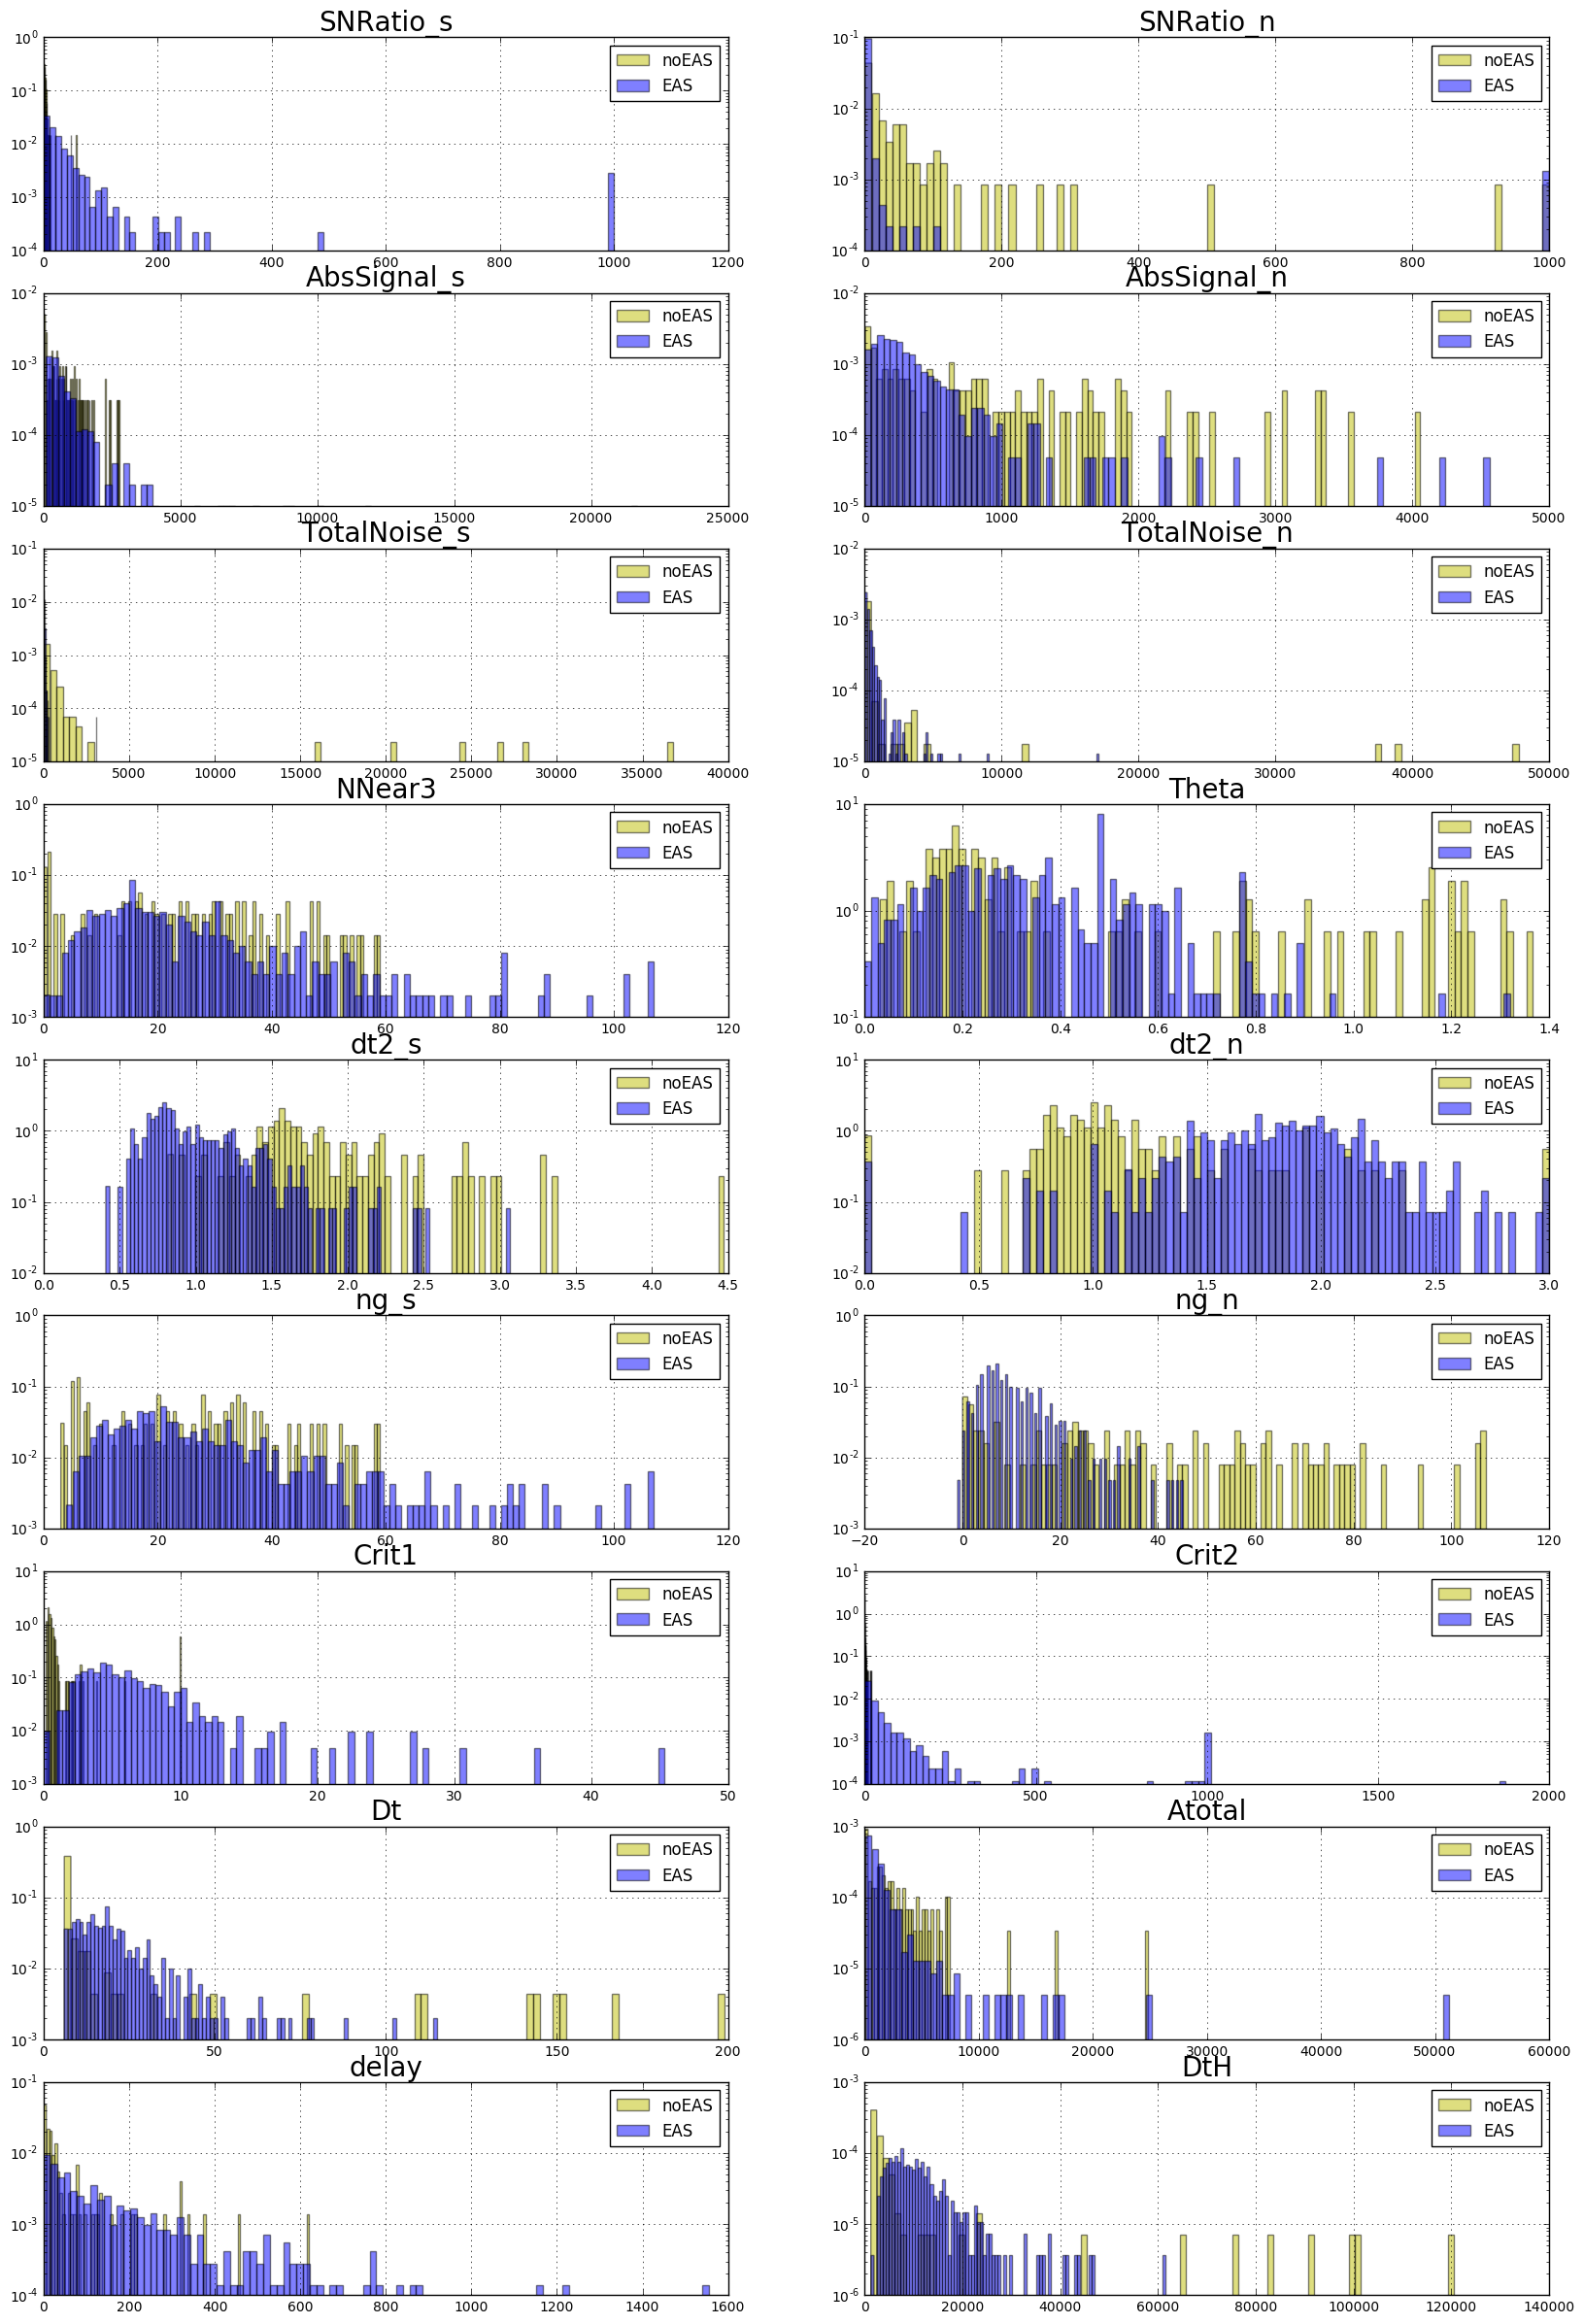

In [74]:
#show=data
show=cand
show['DtH'] = show.Dt*show.H
param=['SNRatio_s','SNRatio_n','AbsSignal_s','AbsSignal_n','TotalNoise_s',       
       'TotalNoise_n','NNear3','Theta','dt2_s','dt2_n','ng_s','ng_n', 'Crit1', 'Crit2',
       'Dt', 'Atotal','delay','DtH'] 


plt.figure(figsize=(20,30))
for i in range(len(param)):
    #plt.subplot(7,2,1+i)
    plt.subplot(9,2,1+i)    
    plt.hist(show[param[i]][show['EAS']==0], bins = 100, alpha = 0.5, color = 'y', label=r"noEAS", normed=True)
    plt.hist(show[param[i]][show['EAS']==1], bins = 100, alpha = 0.5, color = 'b', label=r"EAS", normed=True)
    plt.title(param[i], size = 20)
    plt.legend(loc=1)
    plt.yscale('log')
    plt.grid()

In [23]:
print(len(cand))
cor = cand.corr(method='pearson')
cor_pearson = cor['EAS'].abs().sort_values(ascending=False)
cor_pearson

575


EAS             1.000000
dt2_s           0.623955
ng_n            0.584642
dt2_n           0.508378
Crit1           0.433283
TL3time         0.404503
H               0.368147
AbsSignal_n     0.354240
TotalNoise_s    0.248501
delay           0.233021
TL2time         0.189185
Crit2           0.176359
TRIGGER         0.154589
Theta           0.151192
SNRatio_s       0.149352
SNRatio_n       0.133562
Atotal          0.123948
TotalNoise_n    0.119415
TG5time         0.082581
ng_s            0.058128
NNear3          0.057092
AbsSignal_s     0.052679
Dt              0.046584
Name: EAS, dtype: float64

# Попарные распределения по признакам

In [94]:
#param = ['EAS', 'Crit1', 'dt2_n', 'ng_n','dt2_s', 'AbsSignal_n', 'SNRatio_s', 'Crit2'] #,'SNRatio_n']
param = ['EAS', 'Crit1', 'dt2_n', 'ng_n','dt2_s', 'AbsSignal_n', 'delay', 'Dt','H'] #,'SNRatio_n']

six = cand[param]
six.DtH = six.Dt/six.H
param = ['EAS', 'Crit1', 'dt2_n', 'ng_n','dt2_s', 'AbsSignal_n', 'delay', 'Dt','DtH'] #,'SNRatio_n']

In [95]:
# удалим выбросы, мешающие рассмотреть распределения параметров
six = cand[param][cand['SNRatio_s'] < 300] #120]
#six = six[six['AbsSignal_n'] < 6000]
#six = six[six['Crit2'] < 300]
#six = six[six['dt2_n'] < 3.5]

features = param [1:]
Xset = six[features]
Yset = six['EAS']
print('all:',len(Xset))
print('EAS:',len(Xset[Yset==1]))

all: 561
EAS: 443


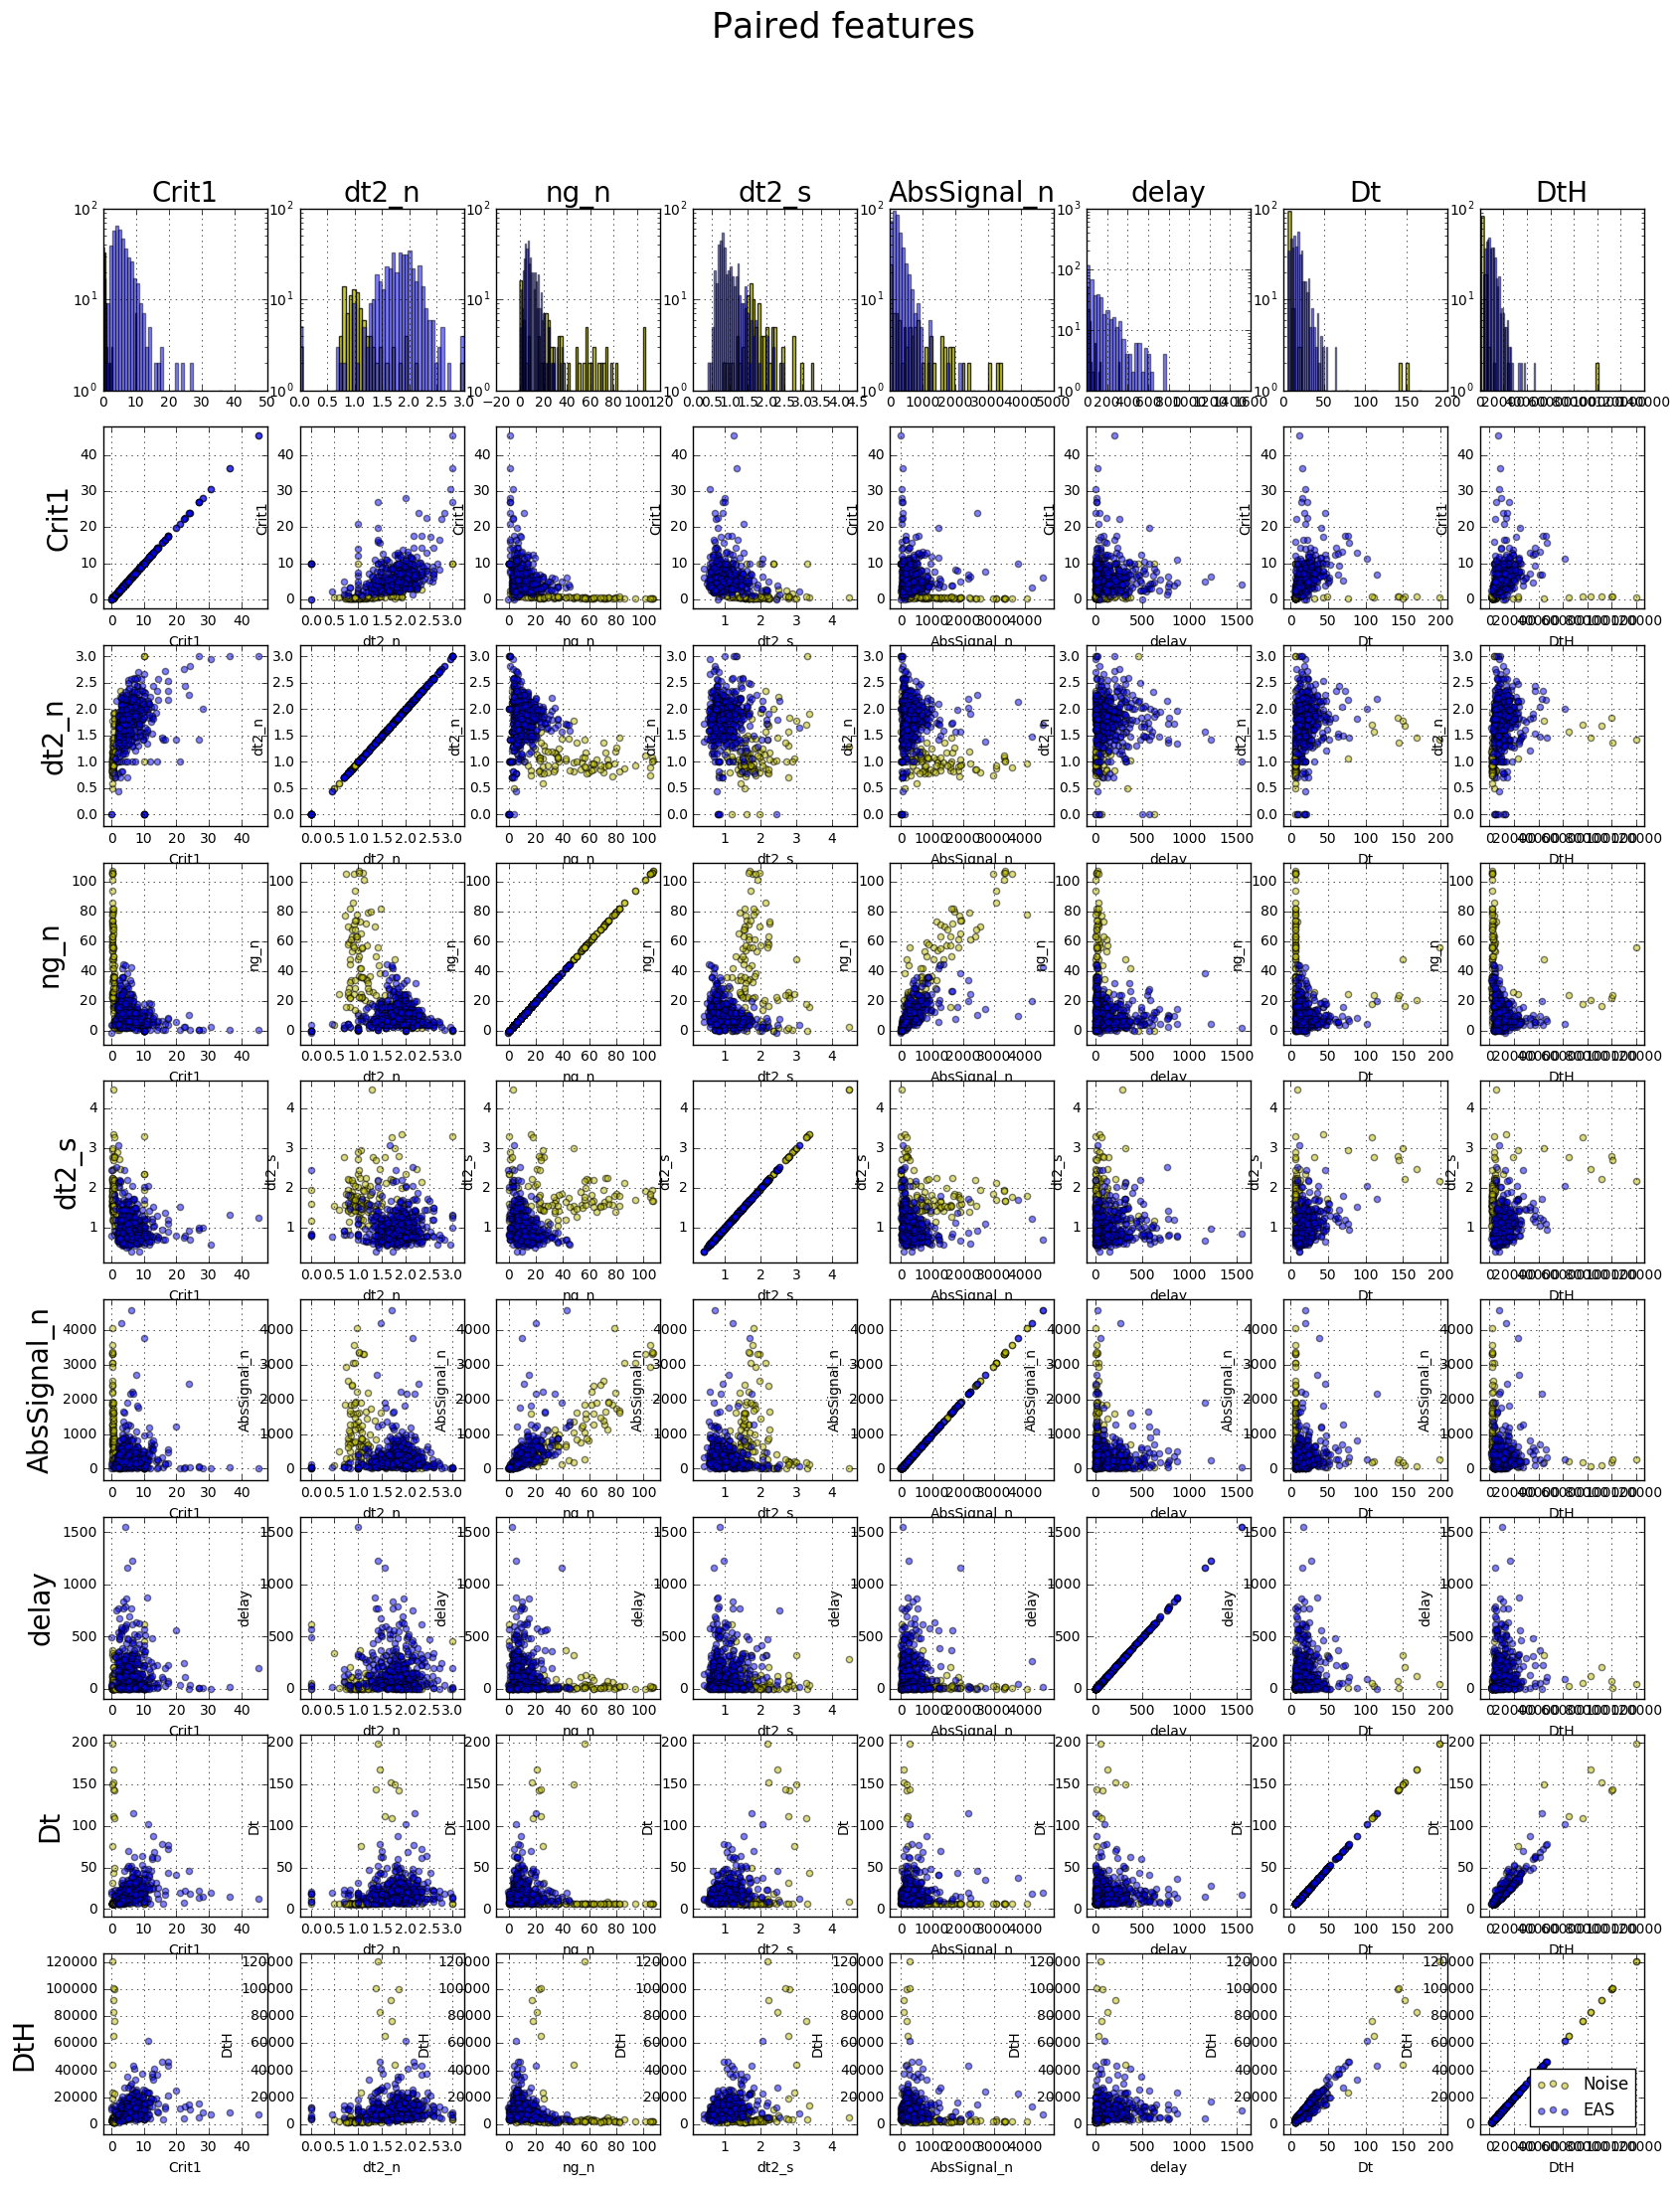

In [96]:
# построим все попарные распределения по признакам с отрезанными выбросами
show_pairs(six,param)

### Корреляции признаков друг с другом

In [97]:
corr = ['EAS', 'ng_n', 'AbsSignal_n', 'SNRatio_s', 'Crit2', 'NNear3','ng_s','TotalNoise_s','TotalNoise_n','Dt','DtH']
param = corr [0:]
check = cand[param]
check.corr(method='pearson')

,EAS,ng_n,AbsSignal_n,SNRatio_s,Crit2,NNear3,ng_s,TotalNoise_s,TotalNoise_n,Dt,DtH
EAS,1.000000,-0.584642,-0.354240,0.149352,0.176359,0.057092,0.058128,-0.248501,-0.119415,0.046584,0.067102
ng_n,-0.584642,1.000000,0.776306,-0.078663,-0.128225,0.438544,0.421521,0.191724,0.102212,-0.122760,-0.166817
AbsSignal_n,-0.354240,0.776306,1.000000,-0.014214,-0.013573,0.606630,0.583748,0.010963,0.064183,-0.090148,-0.123357
SNRatio_s,0.149352,-0.078663,-0.014214,1.000000,0.828401,0.065859,0.063588,-0.043230,-0.005234,0.020841,0.012751
Crit2,0.176359,-0.128225,-0.013573,0.828401,1.000000,0.218143,0.221089,-0.046632,0.056845,0.174489,0.137391
NNear3,0.057092,0.438544,0.606630,0.065859,0.218143,1.000000,0.993887,0.039728,0.219745,0.269845,0.158153
ng_s,0.058128,0.421521,0.583748,0.063588,0.221089,0.993887,1.000000,0.055379,0.238494,0.303359,0.189098
TotalNoise_s,-0.248501,0.191724,0.010963,-0.043230,-0.046632,0.039728,0.055379,1.000000,0.826094,0.319067,0.268397
TotalNoise_n,-0.119415,0.102212,0.064183,-0.005234,0.056845,0.219745,0.238494,0.826094,1.000000,0.385552,0.260914
Dt,0.046584,-0.122760,-0.090148,0.020841,0.174489,0.269845,0.303359,0.319067,0.385552,1.000000,0.953681


In [98]:
check = check[check['Crit2'] < 300]
check = check[check['TotalNoise_s'] < 300]
check.corr(method='pearson')

,EAS,ng_n,AbsSignal_n,SNRatio_s,Crit2,NNear3,ng_s,TotalNoise_s,TotalNoise_n,Dt,DtH
EAS,1.000000,-0.293382,-0.074182,0.250916,0.240710,0.213274,0.205515,-0.493282,0.189067,0.314431,0.340866
ng_n,-0.293382,1.000000,0.600419,0.165571,-0.099669,0.512833,0.509179,0.458577,0.069981,-0.236816,-0.337984
AbsSignal_n,-0.074182,0.600419,1.000000,0.434446,0.155850,0.630287,0.617671,0.244280,0.583133,0.016810,-0.030512
SNRatio_s,0.250916,0.165571,0.434446,1.000000,0.592317,0.486165,0.475149,-0.345190,0.403948,0.216908,0.162161
Crit2,0.240710,-0.099669,0.155850,0.592317,1.000000,0.536963,0.536885,-0.199616,0.648551,0.644061,0.539487
NNear3,0.213274,0.512833,0.630287,0.486165,0.536963,1.000000,0.993501,0.107503,0.741457,0.464215,0.283140
ng_s,0.205515,0.509179,0.617671,0.475149,0.536885,0.993501,1.000000,0.110996,0.738742,0.472628,0.288859
TotalNoise_s,-0.493282,0.458577,0.244280,-0.345190,-0.199616,0.107503,0.110996,1.000000,0.081067,-0.031316,-0.056305
TotalNoise_n,0.189067,0.069981,0.583133,0.403948,0.648551,0.741457,0.738742,0.081067,1.000000,0.615837,0.497894
Dt,0.314431,-0.236816,0.016810,0.216908,0.644061,0.464215,0.472628,-0.031316,0.615837,1.000000,0.934053


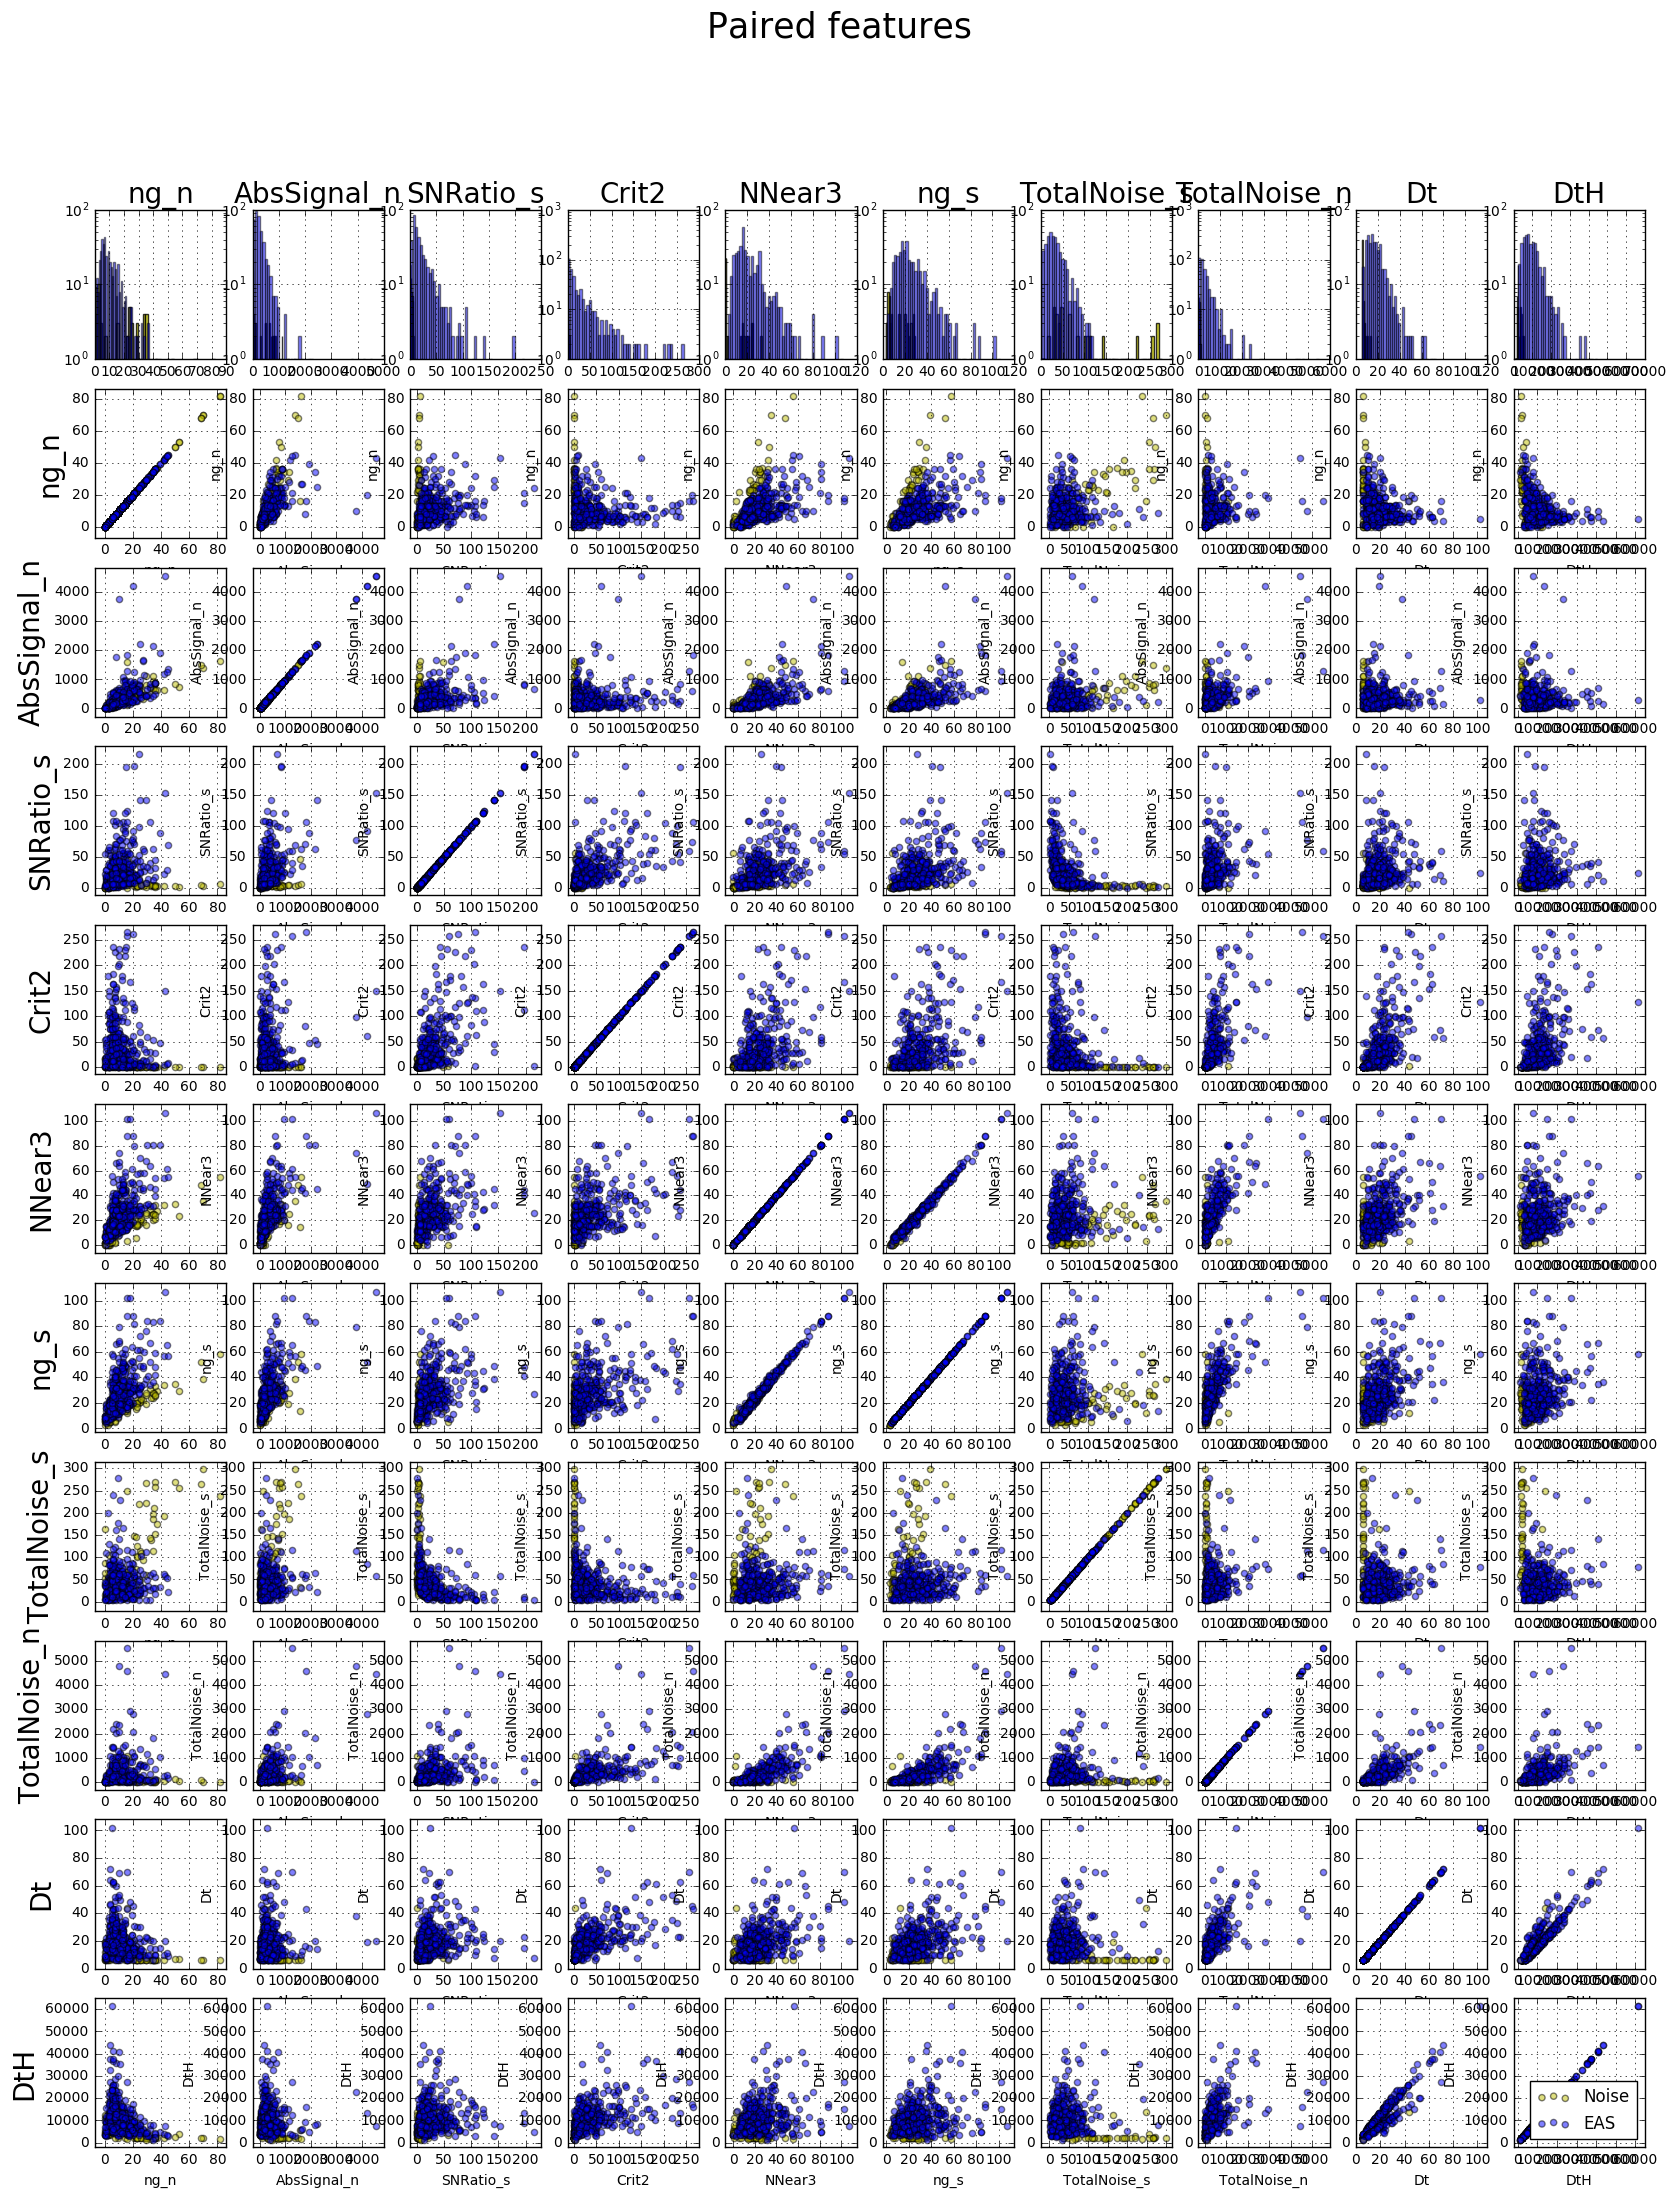

In [99]:
show_pairs(check, corr)

In [31]:
corr = ['EAS', 'ng_n', 'NNear3','ng_s']
param = corr [0:]
check = cand[param]
check.corr(method='pearson')

,EAS,ng_n,NNear3,ng_s
EAS,1.000000,-0.584642,0.057092,0.058128
ng_n,-0.584642,1.000000,0.438544,0.421521
NNear3,0.057092,0.438544,1.000000,0.993887
ng_s,0.058128,0.421521,0.993887,1.000000


In [32]:
check = check[check.ng_n < 40]

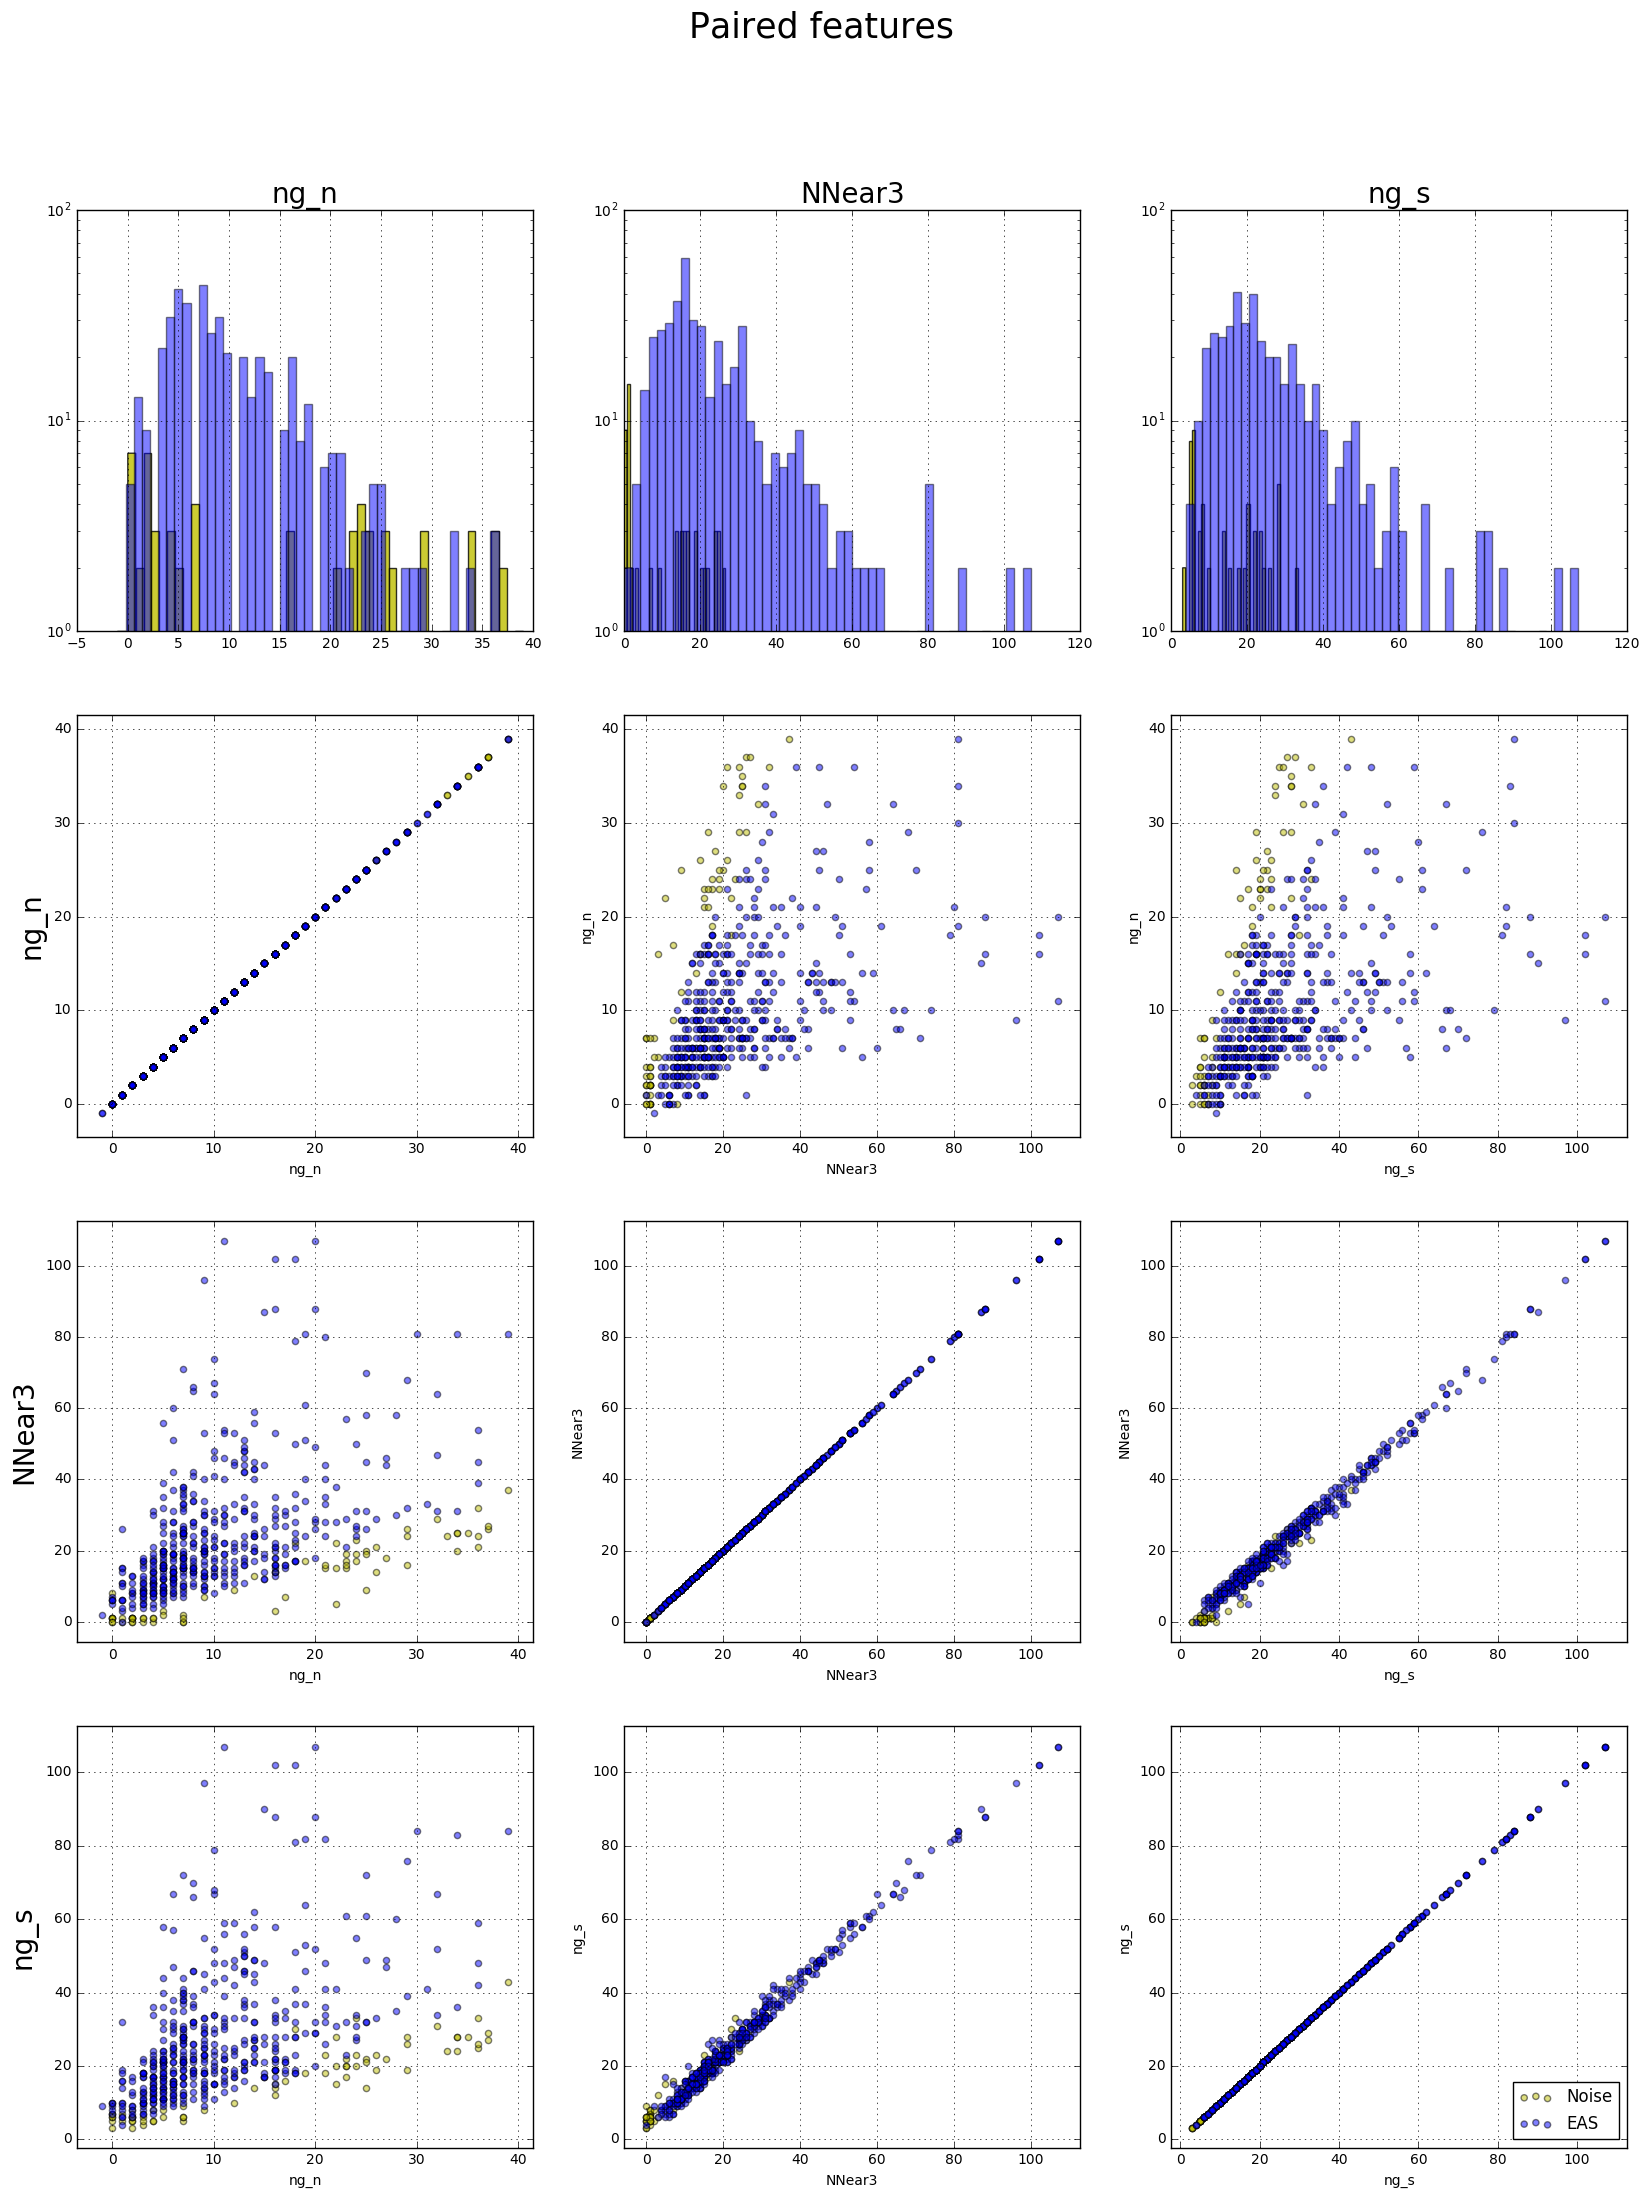

In [33]:
show_pairs(check,param)